In [1]:
import sys
sys.path.append("..")
import ncdm
import scales

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# Example 2) Fuzzy Dark Matter
Goal: Get the suppression of the halo mass function for some fuzzy dark matter models, by fitting the power spectra of a Boltzmann Code.

There are a set of precaculated power spectra in the directory "axioncamb_spectra". These were calculated with the axionCAMB code which is a modified version of CAMB. (see <url>https://github.com/dgrin1/axionCAMB</url>, http://arxiv.org/abs/1410.2896 and also https://camb.info/)

In [2]:
def transfer_ncdm(k, alpha, beta, gamma=5.):
    return (1. + (alpha*k)**beta)**(-gamma)

def read_camb_pkfile(file):
    data = np.loadtxt(file)
    k, Pk = data[:,0], data[:,1]
    return k, Pk

def read_transfer_camb(file_ncdm, file_cdm):
    """Read two camb power spectra and return the squareroot of the ratio"""
    kncdm, Pkncdm = read_camb_pkfile(file_ncdm)
    kcdm, Pkcdm = read_camb_pkfile(file_cdm)
    
    assert np.max(np.abs(kncdm - kcdm)) < 1e-10
    
    return kcdm, np.sqrt(np.abs(Pkncdm/Pkcdm))

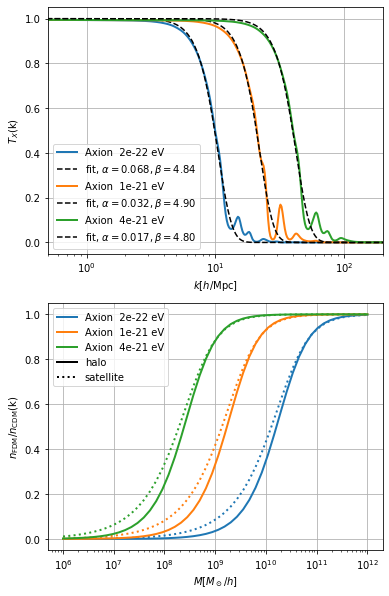

In [3]:
fig, axs = plt.subplots(2,1, figsize=(6,10))

m = np.logspace(6, 12)
for mfdm,file in ((2e-22, "FDM2e-22_matterpower.dat"), (1e-21, "FDM1e-21_matterpower.dat"), (4e-21, "FDM4e-21_matterpower.dat")):
    k, T = read_transfer_camb("axioncamb_spectra/%s" % file, "axioncamb_spectra/CDM_matterpower.dat")

    # Use curvefit to approximate the axion transfer function by our generic
    # ncdm transfer function
    (alpha, beta), cov = curve_fit(transfer_ncdm, k, T, p0=(1., 3.), bounds=(0, np.inf))
    
    axs[0].semilogx(k, T, label=r"Axion  %g eV" % mfdm, lw=2)
    axs[0].semilogx(k, transfer_ncdm(k, alpha, beta), color="black", linestyle="dashed", label=r"fit, $\alpha = %.2g, \beta = %.2f$" % (alpha, beta))
    
    # Evaluate the halo mass function spectrum suppression for the transfer function
    # with the fitted alpha, beta and with gamma=5
    mhm = scales.half_mode_mass(alpha, beta, 5.)
    f = ncdm.mass_function_beta_mhm(m, beta=beta, mhm=mhm, mode="halo")
    fsub = ncdm.mass_function_beta_mhm(m, beta=beta, mhm=mhm, mode="satellite")
    
    p = axs[1].semilogx(m, f, label=r"Axion  %g eV" % mfdm, lw=2)
    axs[1].semilogx(m, fsub, lw=2, linestyle="dotted", color=p[0].get_color())
    
axs[0].set_xlim(5e-1, 2e2)
axs[0].set_xlabel(r"$k [h/$Mpc$]$")
axs[0].set_ylabel(r"$T_X$(k)")
axs[1].set_xlabel(r"$M [M_\odot / h]$")
axs[1].set_ylabel(r"$n_{\rm{FDM}} / n_{\rm{CDM}}$(k)")

axs[1].plot([], lw=2, color="black", label="halo")
axs[1].plot([], linestyle="dotted", lw=2, color="black", label="satellite")
axs[0].legend(loc = "lower left")
axs[1].legend(loc = "upper left")

for ax in axs:
    ax.grid("on")